In [1]:
import warnings
warnings.filterwarnings('ignore')
import pyterrier as pt
if not pt.started():
    pt.init()

import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
import glob
import ir_measures
from ir_measures import * # imports all supported measures, e.g., AP, nDCG, RR, P

Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipykernel_85197/4087205142.py:5: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [2]:
# dataset_name = 'msmarco-passage'
# dataset = pt.get_dataset(f'irds:{dataset_name}')

dataset = pt.get_dataset(f'irds:msmarco-passage')
eval_dataset = pt.get_dataset(f'irds:msmarco-passage/dev')
topics = eval_dataset.get_topics()
# qrels = eval_dataset.get_qrels()

import ir_datasets
eval = ir_datasets.load("msmarco-passage/dev")
# topics = pd.DataFrame(eval.queries_iter())
qrels = pd.DataFrame(eval.qrels_iter())


In [3]:
qrels.shape

(59273, 4)

In [4]:
import json

def save(dict, file):
    with open(file,'w') as f:
        json.dump(dict, f)

def load(file):
    with open(file,'r') as f:
        ms_docids = json.load(f)
    return ms_docids

def Gini(v):
    v = np.array(v)
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = [0]
    for b in bins[1:]:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return gini_val

import statistics
def calc_stats(modelname,df,scoredF, topics):
    if not os.path.exists(scoredF):
        init_msmarco_dict = './results/ms_docids.json'
        docids_score = load(init_msmarco_dict)
        for qid in pt.tqdm(topics['qid']):
            D = df[df['qid'] == np.int64(qid)]
            for dno in D['docno']:
                rank = D[D['docno'] == dno]['rank'].values[0]
                score = 100 / np.log(rank + 2)  # plus 2 because the ranks start from zero
                docids_score[str(dno)] += score
        save(docids_score, scoredF)

    docids_score = load(scoredF)
    scores_df = pd.DataFrame.from_dict(docids_score, orient="index", columns=["score"])
    scores_df = scores_df[scores_df["score"] > 0]
    scores = scores_df['score'].to_list()

    mean = statistics.mean(scores)
    std_dev = statistics.stdev(scores)
    gini_value = Gini(scores)
    return mean, std_dev, gini_value



In [ ]:
# modelname="bm25"
# nfs_dir = '/nfs/resources/cxj/retrievability-bias'
# threshold = 0

# csv = f'./df_bm25_0.csv'
# df = pd.read_csv(csv, index_col=0).reset_index()

# res = []
# for group_key in range(0, 700):
#     scoredF = f'{nfs_dir}/{modelname}/groups/{modelname}_T{threshold}_G{group_key}.json'
#     mean, std, gini = calc_stats(modelname, df, scoredF, None)
#     group_res = [modelname, threshold, group_key, mean, std, gini]
#     print(group_res)
#     res.append(group_res)

# print(f'start creating df per threshold')
# df_threshold = pd.DataFrame(res, columns=['modelname', 'threshold', 'group_key', 'mean', 'std', 'gini'])
# print('saving df per threshold')
# df_threshold.to_csv(f'./result_T{threshold}_group700.csv', ignore_index=True)

In [55]:
# def transform_df(df):
#     df_run = df.rename(columns={'qid':'query_id','docid':'doc_id'})
#     df_run[['query_id','doc_id']] = df_run[['query_id','doc_id']].astype(str)

#     return df_run


In [ ]:
docids_score = load('./bm25_docids_100_threshold_60.json')

In [ ]:
scores_df = pd.DataFrame.from_dict(docids_score, orient="index", columns=["score"])
# scores_df.tail()

In [ ]:
scores_df = scores_df[scores_df["score"] > 0]
scores = scores_df['score'].to_list()
len(scores)

In [101]:
import glob
res = pd.DataFrame()
for file in glob.glob('/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90*.csv'):
    print(file)
    df = pd.concat([res,pd.read_csv(file,index_col=0).reset_index()],ignore_index=True)

df.to_csv('/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90.csv',index=False)

/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_90000.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_40000.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_0.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_80000.csv


In [9]:
df.shape

(2109300, 5)

In [10]:
grouped = df.groupby('qid')
len(grouped.groups.keys())

21093

In [11]:
calc_stats('colbert',df,30,topics)

100%|██████████| 101093/101093 [07:37<00:00, 221.01it/s]


(40.33003088412648, 28.226881905694416, 0.29293872545964966)

In [12]:
topics.shape

(101093, 2)

In [13]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [14]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.0737706373877901, nDCG@10: 0.08367249993447931}

In [22]:
import glob
res = pd.DataFrame()
for file in glob.glob('/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90*.csv'):
    print(file)
    df = pd.concat([res,pd.read_csv(file,index_col=0).reset_index()],ignore_index=True)

/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_90000.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_40000.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_0.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_80000.csv


In [23]:
df.shape

(2109300, 5)

In [24]:
grouped = df.groupby('qid')
len(grouped.groups.keys())

21093

In [25]:
calc_stats('colbert',df,90,topics)

100%|██████████| 101093/101093 [08:18<00:00, 202.94it/s]


(93.73061804189739, 86.13780265597373, 0.4223636245098966)

In [26]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [27]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.03239045863847885, nDCG@10: 0.035517682062096864}

In [15]:
res = pd.DataFrame()
for file in glob.glob('/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_30_*.csv'):
    print(file)
    df = pd.concat([res,pd.read_csv(file,index_col=0).reset_index()],ignore_index=True)

/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_30_0.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_30_40000.csv


In [16]:
df.shape

(6108287, 5)

In [ ]:
grouped = df.groupby('qid')
len(grouped.groups.keys())

In [ ]:
calc_stats('bm25_colbert',df,30,topics)

In [ ]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [ ]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

In [17]:
# df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_30_.csv', index_col=0).reset_index()
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_60_.csv', index_col=0).reset_index()

In [18]:
df.shape

(10108016, 5)

In [45]:
calc_stats('bm25_monot5',df,60,topics)

100%|██████████| 101093/101093 [44:12<00:00, 38.11it/s]


(115.48748108808213, 298.36146566735516, 0.47400568279596994)

In [46]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [47]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.2884650470819681, nDCG@10: 0.3190031825107953}

In [19]:
# df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_30_.csv', index_col=0).reset_index()
# df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_60_.csv', index_col=0).reset_index()
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_90_.csv', index_col=0).reset_index()

In [20]:
df.shape

(10105728, 5)

In [49]:
calc_stats('bm25_monot5',df,90,topics)

100%|██████████| 101093/101093 [44:03<00:00, 38.24it/s]


(361.2086960062334, 855.9334992041702, 0.5108020525703535)

In [50]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [51]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.1435522270533582, nDCG@10: 0.15535085729929}

In [ ]:

results_monot5_100.csv
results_splade_100.csv
results_colbert_100.csv
results_bm25_colbert_100.csv



In [43]:
import tqdm

In [56]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/splade/df_splade_30.csv', index_col=0).reset_index()

In [57]:
df.shape

(10109300, 5)

In [58]:
calc_stats('splade',df,30,topics)

100%|██████████| 101093/101093 [38:29<00:00, 43.76it/s]


(72.07897727079515, 67.02232864644255, 0.39601066004471325)

In [16]:
df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_bm25_100.csv', index_col=0).reset_index()
# calc_stats('bm25',df,0,topics)

In [17]:
df5 =df.head()

In [24]:
df5['r_score'] = df5['rank'].apply(lambda x: 100 / np.log(x + 2))
# df5['rank'].apply(lambda x: print(x))

In [25]:
df5

,qid,docid,docno,rank,score,query,text,r_score
0,1048578,7187236,7187236,0,67.528593,cost of endless pools swim spa,The Endless Pool 15' endless pools swim spa Endless Pool Nightmare Buy A Big Spa Instead Great t...,144.269504
1,1048578,7471198,7471198,1,62.121928,cost of endless pools swim spa,Cal Spas is the leading maker of home resort products. Cal Spas makes a great jetted swim spa wi...,91.023923
2,1048578,5365326,5365326,2,51.958492,cost of endless pools swim spa,"How much does a swim spa cost. 1 A top of the line, branded swim spa 9 feet by 16 feet with the...",72.134752
3,1048578,7187241,7187241,3,51.947947,cost of endless pools swim spa,Disclaimer: Endless Pools (and all other swim spa manufacturers) are intentionally secretive abo...,62.133493
4,1048578,6802210,6802210,4,47.925985,cost of endless pools swim spa,"Endless Pools is one of the first companies to develop this Swim Spa, or “endless” swimming pool...",55.811063


In [7]:
df.head(100).to_csv('./bm25_top100.csv', index=False)

In [8]:
df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_monot5_100.csv', index_col=0).reset_index()
df.head(100).to_csv('./bm25_monot5_top100.csv', index=False)

In [9]:
df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_splade_100.csv', index_col=0).reset_index()
df.head(100).to_csv('./splade_top100.csv', index=False)

In [10]:
df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_colbert_100.csv', index_col=0).reset_index()
df.head(100).to_csv('./colbert_top100.csv', index=False)

In [11]:
df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_bm25_colbert_100.csv', index_col=0).reset_index()
df.head(100).to_csv('./bm25_colbert_top100.csv', index=False)

In [ ]:
# df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_monot5_100.csv', index_col=0).reset_index()
# calc_stats('bm25_monot5',df,0,topics)

In [ ]:
# df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_splade_100.csv', index_col=0).reset_index()
# calc_stats('splade',df,0,topics)

In [ ]:
# df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_colbert_100.csv', index_col=0).reset_index()
# calc_stats('colbert',df,0,topics)

In [ ]:
# df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_bm25_colbert_100.csv', index_col=0).reset_index()
# calc_stats('bm25_colbert',df,0,topics)

In [54]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [55]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.1521238468200753, nDCG@10: 0.16641022307449113}

In [23]:
# df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_30.csv', index_col=0).reset_index()
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_60.csv', index_col=0).reset_index()


In [24]:
df.shape

(10108016, 6)

In [57]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [58]:
calc_stats('bm25',df,60,topics)

100%|██████████| 101093/101093 [45:42<00:00, 36.86it/s]


(115.48748108808213, 334.4713511792268, 0.5019218174868961)

In [59]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.1770989985056333, nDCG@10: 0.20204167208954082}

In [25]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_90.csv', index_col=0).reset_index()

In [26]:
df.shape

(10105728, 6)

In [61]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [62]:
calc_stats('bm25',df,90,topics)

100%|██████████| 101093/101093 [45:46<00:00, 36.81it/s] 


(361.2086960062334, 953.8151508961946, 0.5383489669402687)

In [63]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.09919385080888407, nDCG@10: 0.11094770042458738}

In [27]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_60_0.csv', index_col=0).reset_index()

In [28]:
df.shape

(10108016, 5)

In [65]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [66]:
calc_stats('bm25_colbert',df,60,topics)

100%|██████████| 101093/101093 [43:15<00:00, 38.95it/s]


(115.48748108808213, 299.2952445404816, 0.4757839359945219)

In [67]:
ir_measures.calc_aggregate([nDCG@10, RR], qrels, df2)

{RR: 0.2701930413241178, nDCG@10: 0.3012232637784799}

In [29]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_90_0.csv', index_col=0).reset_index()

In [30]:
df.shape

(10105728, 5)

In [69]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [70]:
calc_stats('bm25_colbert',df,90,topics)

100%|██████████| 101093/101093 [43:26<00:00, 38.79it/s]


(361.2086960062334, 868.2565808556265, 0.5122973596238822)

In [71]:
ir_measures.calc_aggregate([nDCG@10, RR], qrels, df2)

{RR: 0.13745628852665914, nDCG@10: 0.1497218020163707}

In [31]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/splade/df_splade_30.csv', index_col=0).reset_index()

In [32]:
df.shape

(10109300, 5)

In [ ]:

df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [ ]:
df.head()

In [ ]:
calc_stats('splade',df,30,topics)

In [ ]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

In [33]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/splade/df_splade_60.csv', index_col=0).reset_index()


In [34]:
df.shape

(10109300, 5)

In [ ]:
df.head()

In [ ]:
calc_stats('splade',df,60,topics)

In [ ]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

In [42]:
df = pd.read_csv('./results/expt_results.csv')
df = df.round(2)
print(df)

           Model  Gini  nDCG@10  Gini.1  nDCG@10.1  Gini.2  nDCG@10.2  Gini.3  \
0  BM25           0.48  0.21     0.47    0.22       0.50    0.20       0.54     
1  BM25>>Mono-T5  0.43  0.40     0.45    0.38       0.47    0.32       0.51     
2  Splade         0.39  0.45     0.40    0.42       0.41    0.35       0.41     
3  ColBERT        0.39  0.41     0.29    0.08       0.33    0.07       0.42     
4  BM25>>ColBERT  0.43  0.37     0.41    0.20       0.48    0.30       0.51     

   nDCG@10.3  
0  0.11       
1  0.16       
2  0.17       
3  0.04       
4  0.15       


In [43]:
x = [0, 30, 60, 90]

In [44]:
import matplotlib.pyplot as plt

In [45]:
gini_bm25 = df.loc[df['Model'] == 'BM25',['Gini','Gini.1','Gini.2','Gini.3']]
gini_monot5 = df.loc[df['Model'] == 'BM25>>Mono-T5',['Gini','Gini.1','Gini.2','Gini.3']]
gini_Splade = df.loc[df['Model'] == 'Splade',['Gini','Gini.1','Gini.2','Gini.3']]
gini_ColBERT = df.loc[df['Model'] == 'ColBERT',['Gini','Gini.1','Gini.2','Gini.3']]
gini_bm25_ColBERT = df.loc[df['Model'] == 'BM25>>ColBERT',['Gini','Gini.1','Gini.2','Gini.3']]

In [46]:
dfg_bm25 = df.loc[df['Model'] == 'BM25',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]
dfg_monot5 = df.loc[df['Model'] == 'BM25>>Mono-T5',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]
dfg_Splade = df.loc[df['Model'] == 'Splade',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]
dfg_ColBERT = df.loc[df['Model'] == 'ColBERT',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]
dfg_bm25_ColBERT = df.loc[df['Model'] == 'BM25>>ColBERT',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]

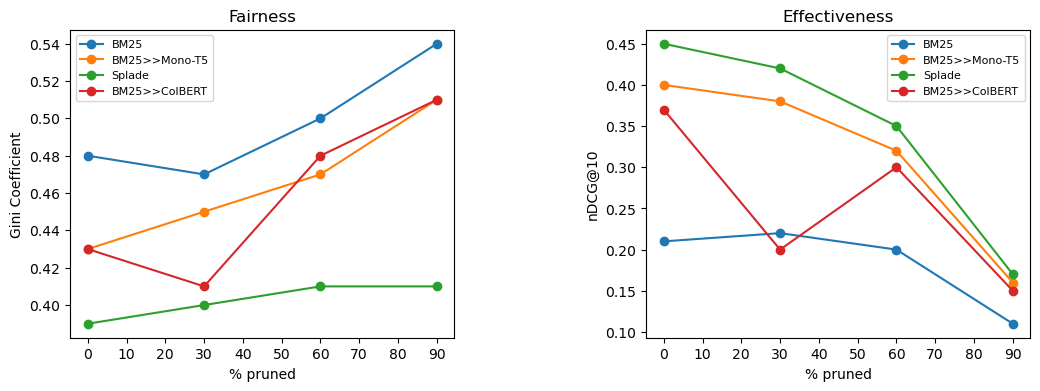

In [51]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(hspace=1, wspace=0.5, left=0.1)

y = gini_bm25.values[0]
ax1.plot(x,y,label='BM25', marker='o')
y = gini_monot5.values[0]
ax1.plot(x,y,label='BM25>>Mono-T5', marker='o')
y = gini_Splade.values[0]
ax1.plot(x,y,label='Splade', marker='o')
# y = gini_ColBERT.values[0]
# ax1.plot(x,y,label='ColBERT', marker='o')
y = gini_bm25_ColBERT.values[0]
ax1.plot(x,y,label='BM25>>ColBERT', marker='o')

ax1.set_title('Fairness')
ax1.set_xlabel('% pruned')
ax1.set_ylabel('Gini Coefficient')
ax1.set_xticks(ticks = [i for i in range(0,100,10)])
ax1.legend(fontsize=8)

y = dfg_bm25.values[0]
ax2.plot(x,y,label='BM25', marker='o')
y = dfg_monot5.values[0]
ax2.plot(x,y,label='BM25>>Mono-T5', marker='o')
y = dfg_Splade.values[0]
ax2.plot(x,y,label='Splade', marker='o')
# y = dfg_ColBERT.values[0]
# ax2.plot(x,y,label='ColBERT', marker='o')
y = dfg_bm25_ColBERT.values[0]
ax2.plot(x,y,label='BM25>>ColBERT', marker='o')

ax2.set_title('Effectiveness')
ax2.set_xlabel('% pruned')
ax2.set_ylabel('nDCG@10')
ax2.set_xticks(ticks = [i for i in range(0,100,10)])
ax2.legend(fontsize=8)

plt.savefig('./results/all_results.pdf', format="pdf", bbox_inches="tight", pad_inches=0.3)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

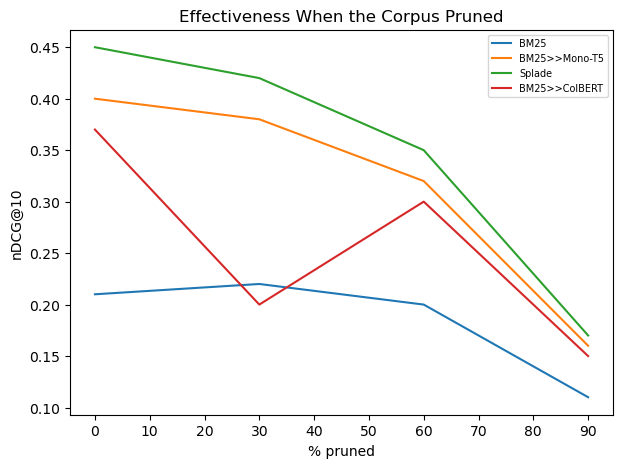

In [50]:
plt.figure(figsize=(7,5))
y = dfg_bm25.values[0]
plt.plot(x,y,label='BM25')
y = dfg_monot5.values[0]
plt.plot(x,y,label='BM25>>Mono-T5')
y = dfg_Splade.values[0]
plt.plot(x,y,label='Splade')
# y = dfg_ColBERT.values[0]
# plt.plot(x,y,label='ColBERT')
y = dfg_bm25_ColBERT.values[0]
plt.plot(x,y,label='BM25>>ColBERT')

plt.title('Effectiveness When the Corpus Pruned')
plt.xlabel('% pruned')
plt.ylabel('nDCG@10')
plt.xticks(ticks = [i for i in range(0,100,10)])
plt.legend(fontsize=7)
plt.show

In [ ]:
# df.plot(x='Gini', y='nDCG@10', kind='line', title='Sales Over Years',xlabel)

# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.lineplot(data=df, x='Gini', y='nDCG@10')
# plt.title('Sales Over Years')
# plt.ylabel('Sales (in Units)')
# plt.show()

In [103]:
sampled_queries = pd.read_csv('./results/smapled_dev_queries_50.csv', index_col=0).reset_index()

In [ ]:
sampled_queries.head(100)

In [104]:
grouped = sampled_queries.groupby('cluster')
print(len(grouped.groups.keys()))

2000


In [ ]:
from itertools import islice
# for group_key, queries_df in islice(grouped,2):

# nfs_dir = f'/nfs/resources/cxj/retrievability-bias'

# res = []
# for modelname in ['bm25', 'bm25_monot5', 'splade', 'colbert', 'bm25_colbert']:
#     for threshold in [0, 30, 60, 90]:
#         csv = f'/nfs/resources/cxj/retrievability-bias/{modelname}/df_{modelname}_{threshold}.csv'
#         print(f'reading {csv}')
#         df = pd.read_csv(csv, index_col=0).reset_index()
#         print(f'start {modelname} ----> {threshold}')
#         for group_key, queries_df in grouped:
#             print(f'start {modelname} ----> threshold {threshold} --> group_key = {group_key}')
#             scoredF = f'{nfs_dir}/{modelname}/groups/{modelname}_T{threshold}_G{group_key}.json'
#             mean, std, gini = calc_stats(modelname, df, scoredF, queries_df)
#             group_res = [modelname, threshold, group_key, mean, std, gini]
#             print(group_res)
#             res.append(group_res)

# print(f'start creating dataframe of len(res) {len(res)}')
# res_df = pd.DataFrame(res, colums=['modelname', 'threshold', 'group_key', 'mean', 'std', 'gini'])
# print('saving dataframe')
# res_df.to_csv(f'{nfs_dir}/{modelname}/result_groups.csv', ignore_index=True)
# print('done')


In [31]:
nfs_dir = f'/nfs/resources/cxj/retrievability-bias'
pt.tqdm.pandas()
res = []
# for modelname in ['bm25', 'bm25_monot5', 'splade', 'colbert', 'bm25_colbert']:
for modelname in ['bm25_colbert']:
    for threshold in [0, 30, 60, 90]:
        print(f'start {modelname} ----> threshold {threshold}')
        csv = f'/nfs/resources/cxj/retrievability-bias/{modelname}/df_{modelname}_{threshold}.csv'
        df = pd.read_csv(csv, index_col=0).reset_index()
        df['r_score'] = df['rank'].progress_apply(lambda x: 100 / np.log(x + 2))
        csv2 = f'/nfs/resources/cxj/retrievability-bias/{modelname}/df_{modelname}_rscore_{threshold}.csv'
        print(f'saving {csv2}')
        df.to_csv(csv2, index=False)
        print(f'done')
        
        # print(f'start {modelname} ----> {threshold}')
        # for group_key, queries_df in grouped:
        #     print(f'start {modelname} ----> threshold {threshold} --> group_key = {group_key}')
        #     scoredF = f'{nfs_dir}/{modelname}/groups/{modelname}_T{threshold}_G{group_key}.json'
        #     mean, std, gini = calc_stats(modelname, df, scoredF, queries_df)
        #     group_res = [modelname, threshold, group_key, mean, std, gini]
        #     print(group_res)
        #     res.append(group_res)

# print(f'start creating dataframe of len(res) {len(res)}')
# res_df = pd.DataFrame(res, colums=['modelname', 'threshold', 'group_key', 'mean', 'std', 'gini'])
# print('saving dataframe')
# res_df.to_csv(f'{nfs_dir}/{modelname}/result_groups.csv', ignore_index=True)
# print('done')

start bm25_colbert ----> threshold 0


100%|██████████| 10108435/10108435 [00:19<00:00, 513173.53it/s]


saving /nfs/resources/cxj/retrievability-bias/bm25_colbert/df_bm25_colbert_rscore_0.csv
done
start bm25_colbert ----> threshold 30


100%|██████████| 6108287/6108287 [00:12<00:00, 505954.64it/s]


saving /nfs/resources/cxj/retrievability-bias/bm25_colbert/df_bm25_colbert_rscore_30.csv
done
start bm25_colbert ----> threshold 60


100%|██████████| 10108016/10108016 [00:19<00:00, 517992.95it/s]


saving /nfs/resources/cxj/retrievability-bias/bm25_colbert/df_bm25_colbert_rscore_60.csv
done
start bm25_colbert ----> threshold 90


100%|██████████| 10105728/10105728 [00:19<00:00, 515528.85it/s]


saving /nfs/resources/cxj/retrievability-bias/bm25_colbert/df_bm25_colbert_rscore_90.csv
done


In [ ]:
def calc_stats_v2(modelname,df,scoredF, topics):
    if not os.path.exists(scoredF):
        qids_to_keep = topics['qid'].to_list()
        mask = np.logical_or.reduce([df["qid"] == val for val in qids_to_keep])
        df_filtered = df[mask]
        grouped = df_filtered.groupby("docno")[['r_score']].sum().reset_index()
        grouped.to_csv(scoredF,index=False)

    scores = grouped['r_score'].to_list()

    mean = statistics.mean(scores)
    std_dev = statistics.stdev(scores)
    gini_value = Gini(scores)
    return mean, std_dev, gini_value

In [ ]:
nfs_dir = f'/nfs/resources/cxj/retrievability-bias'
pt.tqdm.pandas()


modelname = sys.argv[1]

# for modelname in ['bm25', 'bm25_monot5', 'splade', 'colbert', 'bm25_colbert']:
for threshold in [0, 30, 60, 90]:

    csv2 = f'/nfs/resources/cxj/retrievability-bias/{modelname}/df_{modelname}_rscore_{threshold}.csv'
    print(f'reading {csv2}')
    df = pd.read_csv(csv2, index_col=0).reset_index()
    
    res = []
    for cluster_id, queries_df in grouped:
        print(f'start {modelname} ----> threshold {threshold} --> cluster_id = {cluster_id}')
        scoredF = f'{nfs_dir}/{modelname}/groups/{modelname}_T{threshold}_G{cluster_id}.csv'
        mean, std, gini = calc_stats_v2(modelname, df, scoredF, queries_df)
        group_res = [modelname, threshold, cluster_id, mean, std, gini]
        print(group_res)
        res.append(group_res)

    print(f'start creating df per threshold')
    df_threshold = pd.DataFrame(res, columns=['modelname', 'threshold', 'cluster_id', 'mean', 'std', 'gini'])
    res_csv = f'{nfs_dir}/{modelname}/groups/result_T{threshold}_allgroups.csv'
    print(f'saving {res_csv}')
    df_threshold.to_csv(res_csv, index=False)
    print('done')

In [33]:
nfs_dir = f'/nfs/resources/cxj/retrievability-bias'
root_dir = f'/nfs/primary/retrievability-bias'
for modelname in ['bm25', 'bm25_monot5', 'splade', 'colbert', 'bm25_colbert']:
    res = []
    for threshold in [0, 30, 60, 90]:
        res_csv = f'{nfs_dir}/{modelname}/groups/result_T{threshold}_allgroups.csv'
        df_threshold = pd.read_csv(res_csv, index_col=0).reset_index()
        ginis = df_threshold['gini']
        min_gini, mean_gini, max_gini = ginis.min(), ginis.mean(), ginis.max()
        res.append([modelname, threshold, min_gini, mean_gini, max_gini])
        
    res_df = pd.DataFrame(res, columns=['modelname', 'threshold', 'min_gini', 'mean_gini', 'max_gini'])
    res_csv = f'{nfs_dir}/result_{modelname}_stats.csv'
    print(f'saving {res_csv}')
    res_df.to_csv(res_csv, index=False)
    os.system(f'cp -r {res_csv} {root_dir}/results/')

saving /nfs/resources/cxj/retrievability-bias/result_bm25_stats.csv
saving /nfs/resources/cxj/retrievability-bias/result_bm25_monot5_stats.csv
saving /nfs/resources/cxj/retrievability-bias/result_splade_stats.csv
saving /nfs/resources/cxj/retrievability-bias/result_colbert_stats.csv
saving /nfs/resources/cxj/retrievability-bias/result_bm25_colbert_stats.csv


In [2]:
import pandas as pd
root_dir = f'/root/retrievability-bias'
nfs_dir = f'/nfs/resources/cxj/retrievability-bias'
modelname = 't5-base-msmarco-epoch-5'
ranker='tctcolbert'
threshold = 3

import pyterrier_dr
import shutil
import os
import tqdm
model = pyterrier_dr.TctColBert('castorini/tct_colbert-v2-hnp-msmarco')

In [3]:
# csv = f'{nfs_dir}/bm25/{modelname}_unprunned_df.csv'

csv = f'{nfs_dir}/{modelname}_prunned_{30 * threshold}_df.csv'
df = pd.read_csv(csv, index_col=0).reset_index()

In [4]:
del df['prob']

In [5]:
df[['docno','text']] = df[['docno','text']].astype(str)

In [6]:
df.shape

(884183, 2)

In [38]:
df3 = pd.DataFrame([
   {'docno': '0', 'text': 'The Five Find-Outers and Dog, also known as The Five Find-Outers, is a series of children\'s mystery books written by Enid Blyton.'},
   {'docno': '1', 'text': 'City is a 1952 science fiction fix-up novel by American writer Clifford D. Simak.'},
 ])

In [39]:
print(df3.head())

   index docno  \
0      0     0   
1      1     1   

                                                                                                  text  
0  The Five Find-Outers and Dog, also known as The Five Find-Outers, is a series of children's myst...  
1                    City is a 1952 science fiction fix-up novel by American writer Clifford D. Simak.  


In [35]:
df.head()

,text,docno
0,Manhattan Project. The Manhattan Project was a research and development undertaking during World...,7
1,Tutorial: Introduction to Restorative Justice. Restorative justice is a theory of justice that e...,12
2,Phloem is a conductive (or vascular) tissue found in plants. Phloem carries the products of phot...,20
3,Industrial Workers of the World. In 1905 representatives of 43 groups who opposed the policies o...,36
4,"The World Bank ranked Costa Rica as having the highest life expectancy, at 78.7 years. This figu...",47


In [9]:
# rng = [str(docno) for docno in range(8840985,8841820)]
rng = [str(docno) for docno in range(8840800, 8840985)]
iterable_dict = df[df['docno'].isin(rng)].to_dict(orient="records")

In [10]:
# for record in iterable_dict:
#     print(record)

In [11]:
index_path = f"{root_dir}/{modelname}-{ranker}-index-threshold-{threshold}_test.flex"
if os.path.exists(index_path):
    shutil.rmtree(index_path)
    print(f'existing index file at {index_path} removed')

print(f'indexing into {index_path}')
index = pyterrier_dr.FlexIndex(f'{index_path}')

# idx_pipeline = DocumentFilter(qual_signal=qual_signal, threshold=threshold) >> model >> index
idx_pipeline =  model >> index

# idx_pipeline.index(df3)
idx_pipeline.index(iterable_dict)

print(f'indexing {index_path} done')

existing index file at /root/retrievability-bias/t5-base-msmarco-epoch-5-tctcolbert-index-threshold-3_test.flex removed
indexing into /root/retrievability-bias/t5-base-msmarco-epoch-5-tctcolbert-index-threshold-3_test.flex


indexing: 25dvec [00:00, 162.40dvec/s]

8840801 -----> 8840981
indexing /root/retrievability-bias/t5-base-msmarco-epoch-5-tctcolbert-index-threshold-3_test.flex done


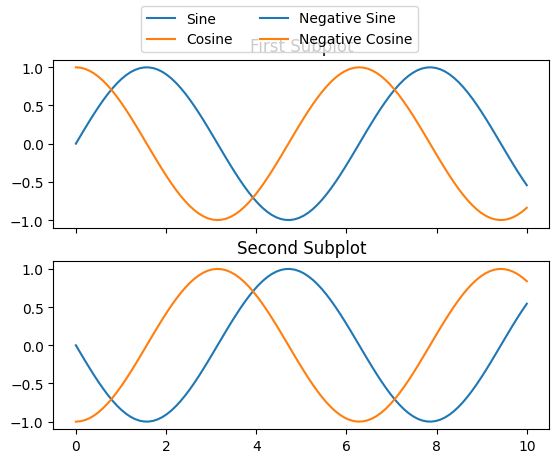

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

fig, axs = plt.subplots(2, 1, sharex=True)

# Plotting on the first subplot
line1, = axs[0].plot(x, y1, label='Sine')
line2, = axs[0].plot(x, y2, label='Cosine')
axs[0].set_title('First Subplot')

# Plotting on the second subplot
line3, = axs[1].plot(x, -y1, label='Negative Sine')
line4, = axs[1].plot(x, -y2, label='Negative Cosine')
axs[1].set_title('Second Subplot')

# Creating a common legend
fig.legend(handles=[line1, line2, line3, line4], loc='upper center', ncol=2)

plt.show()
